In [8]:
%pylab inline
import os,sys,re
import pickle
from builtins import sum as bsum
from importlib import reload


Populating the interactive namespace from numpy and matplotlib


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['load', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [10]:
import units; reload(units); UNITS = units.UNITS; 

In [19]:
HZ = UNITS.Hz
SEC= UNITS.s
M  = UNITS.m
UM = UNITS.um


In [11]:
import surrogate; reload(surrogate)
import fisher_plumes_tools as fpt;      reload(fpt)
import fisher_plumes as fp;             reload(fp)
import utils; reload(utils);
import proc; reload(proc);

INFO:surrogate:Surrogate simulation data available for: ['no_info', 'one_info', 'two_info', 'high', 'spike_and_slab', 'blue', 'red', 'all_equal']


In [68]:
data = {}
for pw in "pw":
    for m in [0,1]:
        for i in range(20):
            print("Loading data for method", m, "and seed", i)
            init = {"sim_name":"surr_all_equal", "surrogate_k":{"p":4,"w":0}[pw], "method":m, "random_seed":i}
            data[f"s={pw}{m}_{i}"] =   proc.load_data(init_filter = init,
                                                   compute_filter = {"window_shape":'hann',
                                                 "window_length":1 * UNITS.second,
                                                                     "fit_k":True})[0]
            
        


                    proc 2023/09/27 08:57:48     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 0, 'random_seed': 0} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.00/71208a4302da978a.p, last modified 2023-09-27 08:18:24.


Loading data for method 0 and seed 0


                    proc 2023/09/27 08:57:48     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:48     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 0, 'random_seed': 1} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.01/125f7a0924d72de0.p, last modified 2023-09-27 08:18:20.


Loading data for method 0 and seed 1


                    proc 2023/09/27 08:57:49     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:49     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 0, 'random_seed': 2} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.02/214b2e8b63447361.p, last modified 2023-09-27 08:17:49.


Loading data for method 0 and seed 2


                    proc 2023/09/27 08:57:49     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:49     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 0, 'random_seed': 3} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.03/d8e1595aaf13c85c.p, last modified 2023-09-27 08:17:50.


Loading data for method 0 and seed 3


                    proc 2023/09/27 08:57:49     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:49     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 0, 'random_seed': 4} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.04/ba0baef512062843.p, last modified 2023-09-27 08:18:11.


Loading data for method 0 and seed 4


                    proc 2023/09/27 08:57:49     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:49     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 0, 'random_seed': 5} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.05/572896233b8c3011.p, last modified 2023-09-27 08:18:16.


Loading data for method 0 and seed 5


                    proc 2023/09/27 08:57:49     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:49     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 0, 'random_seed': 6} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.06/dec92b1a34240412.p, last modified 2023-09-27 08:19:00.


Loading data for method 0 and seed 6


                    proc 2023/09/27 08:57:50     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:50     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 0, 'random_seed': 7} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.07/d2eaea531b0f1fc3.p, last modified 2023-09-27 08:18:22.


Loading data for method 0 and seed 7


                    proc 2023/09/27 08:57:50     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:50     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 0, 'random_seed': 8} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.08/a0a129ef5b6373d7.p, last modified 2023-09-27 08:18:27.


Loading data for method 0 and seed 8


                    proc 2023/09/27 08:57:50     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:50     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 0, 'random_seed': 9} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.09/8bcb592e716ef3e3.p, last modified 2023-09-27 08:18:37.


Loading data for method 0 and seed 9


                    proc 2023/09/27 08:57:50     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:50     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 0, 'random_seed': 10} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.010/02520f6e4ed59d3f.p, last modified 2023-09-27 08:18:27.


Loading data for method 0 and seed 10


                    proc 2023/09/27 08:57:50     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:50     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 0, 'random_seed': 11} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.011/d95051fdae8a51aa.p, last modified 2023-09-27 08:18:30.


Loading data for method 0 and seed 11


                    proc 2023/09/27 08:57:51     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:51     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 0, 'random_seed': 12} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.012/26969fd3b4d303e6.p, last modified 2023-09-27 08:18:31.


Loading data for method 0 and seed 12


                    proc 2023/09/27 08:57:51     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:51     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 0, 'random_seed': 13} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.013/8a2e9558e9232fc2.p, last modified 2023-09-27 08:18:24.


Loading data for method 0 and seed 13


                    proc 2023/09/27 08:57:54     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:54     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 0, 'random_seed': 14} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.014/ca40bbdae16efda4.p, last modified 2023-09-27 08:18:36.


Loading data for method 0 and seed 14


                    proc 2023/09/27 08:57:54     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:54     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 0, 'random_seed': 15} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.015/ef8499aa5a11bdf0.p, last modified 2023-09-27 08:18:08.


Loading data for method 0 and seed 15


                    proc 2023/09/27 08:57:55     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:55     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 0, 'random_seed': 16} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.016/1d63402a54dc91e8.p, last modified 2023-09-27 08:18:03.


Loading data for method 0 and seed 16


                    proc 2023/09/27 08:57:55     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:55     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 0, 'random_seed': 17} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.017/0c23a4d9f1c44ad8.p, last modified 2023-09-27 08:18:15.


Loading data for method 0 and seed 17


                    proc 2023/09/27 08:57:55     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:55     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 0, 'random_seed': 18} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.018/7ca30198a701f478.p, last modified 2023-09-27 08:17:53.


Loading data for method 0 and seed 18


                    proc 2023/09/27 08:57:55     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:55     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 0, 'random_seed': 19} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.019/f300221dac202c04.p, last modified 2023-09-27 08:18:18.


Loading data for method 0 and seed 19


                    proc 2023/09/27 08:57:55     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:55     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 1, 'random_seed': 0} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.10/62cdf50a469e4ed4.p, last modified 2023-09-27 08:17:16.


Loading data for method 1 and seed 0


                    proc 2023/09/27 08:57:56     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:56     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 1, 'random_seed': 1} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.11/38c434431212dbf5.p, last modified 2023-09-27 08:17:09.


Loading data for method 1 and seed 1


                    proc 2023/09/27 08:57:56     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:56     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 1, 'random_seed': 2} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.12/0f1fdf713d7a4e7c.p, last modified 2023-09-27 08:17:16.


Loading data for method 1 and seed 2


                    proc 2023/09/27 08:57:56     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:56     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 1, 'random_seed': 3} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.13/31db26d3e8a7c2b9.p, last modified 2023-09-27 08:17:14.


Loading data for method 1 and seed 3


                    proc 2023/09/27 08:57:56     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:56     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 1, 'random_seed': 4} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.14/e84223585789b6dc.p, last modified 2023-09-27 08:17:13.


Loading data for method 1 and seed 4


                    proc 2023/09/27 08:57:56     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:56     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 1, 'random_seed': 5} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.15/859e04f7f4aa8136.p, last modified 2023-09-27 08:17:08.


Loading data for method 1 and seed 5


                    proc 2023/09/27 08:57:57     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:57     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 1, 'random_seed': 6} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.16/464b5b5dd0eb9ecc.p, last modified 2023-09-27 08:17:13.


Loading data for method 1 and seed 6


                    proc 2023/09/27 08:57:57     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:57     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 1, 'random_seed': 7} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.17/3266d9e11a31130b.p, last modified 2023-09-27 08:17:12.


Loading data for method 1 and seed 7


                    proc 2023/09/27 08:57:57     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:57     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 1, 'random_seed': 8} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.18/10ce4848447b50fd.p, last modified 2023-09-27 08:17:20.


Loading data for method 1 and seed 8


                    proc 2023/09/27 08:57:57     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:57     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 1, 'random_seed': 9} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.19/0a4ad1b1fa044293.p, last modified 2023-09-27 08:17:16.


Loading data for method 1 and seed 9


                    proc 2023/09/27 08:57:58     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:58     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 1, 'random_seed': 10} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.110/02fc3dfe6b53fd8a.p, last modified 2023-09-27 08:17:14.


Loading data for method 1 and seed 10


                    proc 2023/09/27 08:57:58     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:58     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 1, 'random_seed': 11} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.111/7614f43674bafa8a.p, last modified 2023-09-27 08:17:05.


Loading data for method 1 and seed 11


                    proc 2023/09/27 08:57:58     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:58     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 1, 'random_seed': 12} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.112/372ca3ae4a85a4ba.p, last modified 2023-09-27 08:17:17.


Loading data for method 1 and seed 12


                    proc 2023/09/27 08:57:58     INFO: Returning 1 results.


Loading data for method 1 and seed 13


                    proc 2023/09/27 08:57:58     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 1, 'random_seed': 13} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.113/e9b4bc0fbed44113.p, last modified 2023-09-27 08:17:14.


                    proc 2023/09/27 08:57:59     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:59     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 1, 'random_seed': 14} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.114/173ca3fc5720e7f1.p, last modified 2023-09-27 08:17:25.


Loading data for method 1 and seed 14


                    proc 2023/09/27 08:57:59     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:59     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 1, 'random_seed': 15} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.115/99855db2622dc5ba.p, last modified 2023-09-27 08:17:08.


Loading data for method 1 and seed 15


                    proc 2023/09/27 08:57:59     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:59     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 1, 'random_seed': 16} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.116/7a8f4ad717f894e9.p, last modified 2023-09-27 08:17:11.


Loading data for method 1 and seed 16


                    proc 2023/09/27 08:57:59     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:59     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 1, 'random_seed': 17} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.117/253fe885e599386c.p, last modified 2023-09-27 08:17:08.


Loading data for method 1 and seed 17


                    proc 2023/09/27 08:57:59     INFO: Returning 1 results.


                    proc 2023/09/27 08:57:59     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 1, 'random_seed': 18} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.118/ed89852599a9f575.p, last modified 2023-09-27 08:17:16.


Loading data for method 1 and seed 18


                    proc 2023/09/27 08:58:00     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:00     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4, 'method': 1, 'random_seed': 19} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/sup.meth.119/3354e804094efc04.p, last modified 2023-09-27 08:17:11.


Loading data for method 1 and seed 19


                    proc 2023/09/27 08:58:00     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:00     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 0, 'random_seed': 0} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.00/bbb4368db91cc207.p, last modified 2023-09-27 08:51:33.


Loading data for method 0 and seed 0


                    proc 2023/09/27 08:58:00     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:00     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 0, 'random_seed': 1} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.01/8d882d4c92616f9c.p, last modified 2023-09-27 08:51:38.


Loading data for method 0 and seed 1


                    proc 2023/09/27 08:58:01     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:01     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 0, 'random_seed': 2} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.02/a225eb3960453568.p, last modified 2023-09-27 08:51:53.


Loading data for method 0 and seed 2


                    proc 2023/09/27 08:58:01     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:01     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 0, 'random_seed': 3} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.03/02c3810fcb4e9261.p, last modified 2023-09-27 08:51:49.


Loading data for method 0 and seed 3


                    proc 2023/09/27 08:58:02     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:02     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 0, 'random_seed': 4} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.04/443cf7686b82bc66.p, last modified 2023-09-27 08:51:42.


Loading data for method 0 and seed 4


                    proc 2023/09/27 08:58:02     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:02     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 0, 'random_seed': 5} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.05/77d863884db76329.p, last modified 2023-09-27 08:51:37.


Loading data for method 0 and seed 5


                    proc 2023/09/27 08:58:02     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:02     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 0, 'random_seed': 6} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.06/7a7b38a1fa15caab.p, last modified 2023-09-27 08:51:51.


Loading data for method 0 and seed 6


                    proc 2023/09/27 08:58:03     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:03     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 0, 'random_seed': 7} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.07/94bdaa42c7bc1f10.p, last modified 2023-09-27 08:51:50.


Loading data for method 0 and seed 7


                    proc 2023/09/27 08:58:03     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:03     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 0, 'random_seed': 8} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.08/69eb707449622096.p, last modified 2023-09-27 08:51:35.


Loading data for method 0 and seed 8


                    proc 2023/09/27 08:58:04     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:04     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 0, 'random_seed': 9} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.09/73860768c936d72e.p, last modified 2023-09-27 08:51:33.


Loading data for method 0 and seed 9


                    proc 2023/09/27 08:58:04     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:04     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 0, 'random_seed': 10} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.010/5fcb3c8b95f2d74f.p, last modified 2023-09-27 08:51:41.


Loading data for method 0 and seed 10


                    proc 2023/09/27 08:58:05     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:05     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 0, 'random_seed': 11} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.011/95ebf595735adbcd.p, last modified 2023-09-27 08:51:41.


Loading data for method 0 and seed 11


                    proc 2023/09/27 08:58:05     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:05     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 0, 'random_seed': 12} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.012/9b2541ebb56681a5.p, last modified 2023-09-27 08:51:39.


Loading data for method 0 and seed 12


                    proc 2023/09/27 08:58:05     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:05     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 0, 'random_seed': 13} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.013/5959fbe5865cfa77.p, last modified 2023-09-27 08:51:30.


Loading data for method 0 and seed 13


                    proc 2023/09/27 08:58:06     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:06     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 0, 'random_seed': 14} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.014/12d803c48f9de6f1.p, last modified 2023-09-27 08:51:43.


Loading data for method 0 and seed 14


                    proc 2023/09/27 08:58:06     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:06     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 0, 'random_seed': 15} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.015/032b8232c131da6f.p, last modified 2023-09-27 08:51:36.


Loading data for method 0 and seed 15


                    proc 2023/09/27 08:58:07     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:07     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 0, 'random_seed': 16} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.016/a0f7f20cc8eb428d.p, last modified 2023-09-27 08:51:35.


Loading data for method 0 and seed 16


                    proc 2023/09/27 08:58:07     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:07     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 0, 'random_seed': 17} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.017/df0386a58b8ad210.p, last modified 2023-09-27 08:52:01.


Loading data for method 0 and seed 17


                    proc 2023/09/27 08:58:07     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:07     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 0, 'random_seed': 18} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.018/c361a339ac71e83b.p, last modified 2023-09-27 08:52:02.


Loading data for method 0 and seed 18


                    proc 2023/09/27 08:58:08     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:08     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 0, 'random_seed': 19} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.019/76b132294a23c018.p, last modified 2023-09-27 08:51:35.


Loading data for method 0 and seed 19


                    proc 2023/09/27 08:58:08     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:08     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 1, 'random_seed': 0} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.10/ae3c677da74bc89c.p, last modified 2023-09-27 08:50:57.


Loading data for method 1 and seed 0


                    proc 2023/09/27 08:58:09     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:09     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 1, 'random_seed': 1} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.11/a0f15603e6920821.p, last modified 2023-09-27 08:50:52.


Loading data for method 1 and seed 1


                    proc 2023/09/27 08:58:09     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:09     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 1, 'random_seed': 2} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.12/455e04d8a91b1b9d.p, last modified 2023-09-27 08:50:47.


Loading data for method 1 and seed 2


                    proc 2023/09/27 08:58:10     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:10     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 1, 'random_seed': 3} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.13/fca3236f706c6784.p, last modified 2023-09-27 08:50:52.


Loading data for method 1 and seed 3


                    proc 2023/09/27 08:58:10     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:10     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 1, 'random_seed': 4} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.14/08afd70a27bce5e0.p, last modified 2023-09-27 08:50:44.


Loading data for method 1 and seed 4


                    proc 2023/09/27 08:58:10     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:10     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 1, 'random_seed': 5} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.15/4e9f995f4b7630b9.p, last modified 2023-09-27 08:50:46.


Loading data for method 1 and seed 5


                    proc 2023/09/27 08:58:11     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:11     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 1, 'random_seed': 6} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.16/a669f2a258f33e9d.p, last modified 2023-09-27 08:50:48.


Loading data for method 1 and seed 6


                    proc 2023/09/27 08:58:11     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:11     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 1, 'random_seed': 7} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.17/c48f8aca7a87f5f6.p, last modified 2023-09-27 08:50:47.


Loading data for method 1 and seed 7


                    proc 2023/09/27 08:58:12     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:12     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 1, 'random_seed': 8} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.18/96767a623c7c33b5.p, last modified 2023-09-27 08:50:54.


Loading data for method 1 and seed 8


                    proc 2023/09/27 08:58:12     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:12     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 1, 'random_seed': 9} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.19/e0831fde06075fe0.p, last modified 2023-09-27 08:50:44.


Loading data for method 1 and seed 9


                    proc 2023/09/27 08:58:12     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:12     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 1, 'random_seed': 10} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.110/c34002087a59e9a1.p, last modified 2023-09-27 08:50:47.


Loading data for method 1 and seed 10


                    proc 2023/09/27 08:58:13     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:13     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 1, 'random_seed': 11} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.111/45917d32eaa10a26.p, last modified 2023-09-27 08:50:47.


Loading data for method 1 and seed 11


                    proc 2023/09/27 08:58:13     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:13     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 1, 'random_seed': 12} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.112/edd1808682d851bc.p, last modified 2023-09-27 08:50:48.


Loading data for method 1 and seed 12


                    proc 2023/09/27 08:58:14     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:14     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 1, 'random_seed': 13} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.113/b84a11545a63ec69.p, last modified 2023-09-27 08:50:44.


Loading data for method 1 and seed 13


                    proc 2023/09/27 08:58:14     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:14     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 1, 'random_seed': 14} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.114/2ed4d67ade77fc82.p, last modified 2023-09-27 08:50:48.


Loading data for method 1 and seed 14


                    proc 2023/09/27 08:58:14     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:15     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 1, 'random_seed': 15} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.115/6724f6363f09b9f3.p, last modified 2023-09-27 08:50:55.


Loading data for method 1 and seed 15


                    proc 2023/09/27 08:58:15     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:15     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 1, 'random_seed': 16} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.116/99eed3f5a90ad1ef.p, last modified 2023-09-27 08:50:53.


Loading data for method 1 and seed 16


                    proc 2023/09/27 08:58:15     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:15     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 1, 'random_seed': 17} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.117/89b4e25956b3b1ca.p, last modified 2023-09-27 08:50:48.


Loading data for method 1 and seed 17


                    proc 2023/09/27 08:58:16     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:16     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 1, 'random_seed': 18} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.118/106522f773c60af0.p, last modified 2023-09-27 08:50:43.


Loading data for method 1 and seed 18


                    proc 2023/09/27 08:58:16     INFO: Returning 1 results.


                    proc 2023/09/27 08:58:16     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0, 'method': 1, 'random_seed': 19} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': True} from proc/suw.meth.119/6c4c23522bc31071.p, last modified 2023-09-27 08:50:49.


Loading data for method 1 and seed 19


                    proc 2023/09/27 08:58:17     INFO: Returning 1 results.


In [69]:
dd = list(data["s=w0_1"]["sims"].keys())

In [70]:
data["s=w0_1"]["sim0"]["c"].shape

(1500, 16)

In [101]:
pw = "p"
c0 = np.array([data[f"s={pw}0_{i}"]["sim0"]["c"] for i in range(20)])
s0 = np.array([data[f"s={pw}0_{i}"]["sim0"]["s"] for i in range(20)])
c1 = np.array([data[f"s={pw}1_{i}"]["sim0"]["c"] for i in range(20)])
s1 = np.array([data[f"s={pw}1_{i}"]["sim0"]["s"] for i in range(20)])


In [102]:
c0.shape

(20, 1500, 16)

In [119]:
n_freq =c0.shape[1]
nt = 2*n_freq + 1
fs = 50
f = arange(n_freq)/nt*fs
k = {"p":4, "w":0}
a = 1/(np.maximum(f,1)**2)

In [126]:
c0_ = c0 * a[None,:,None]
s0_ = s0 * a[None,:,None]
c1_ = c1 * a[None,:,None]
s1_ = s1 * a[None,:,None]

In [79]:
plt.style.use("default")

0.99891614557197


(-0.028187852242449605,
 0.05446955730855625,
 -0.028187852242449605,
 0.05446955730855625)

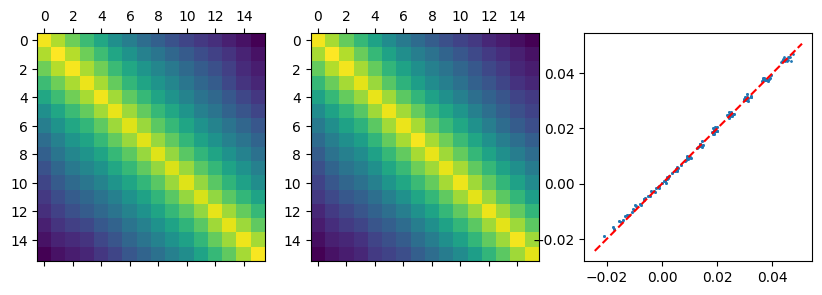

In [136]:
figure(figsize=(10,5))
C0 = np.mean([cov(c0_[i].T) for i in range(20)], axis=0)
C1 = np.mean([cov(c1_[i].T) for i in range(20)], axis=0)
subplot(1,3,1); matshow(C0, fignum=False)
subplot(1,3,2); matshow(C1, fignum=False)
print(corrcoef(C0.flatten(), C1.flatten())[0,1])
subplot(1,3,3); scatter(C0.flatten(), C1.flatten(), s=1); plot(xlim(), xlim(), "r--"); axis("square")

In [95]:
norm(c0[:,1,:]-c1[:,1,:])

27.309659016724037

In [91]:
cov(X0).shape

(20, 20)

In [90]:
X0.shape

(20, 16)

In [72]:
c0.shape

(20, 1500, 16)